In [1]:
# general
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd
import snowflake.connector

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
import matplotlib.pyplot as plt

# 0. Read Training Data

In [5]:
import xgboost  
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold

In [6]:
training_data = pd.read_csv('training_data_low_budget_movies.csv')

In [7]:
training_data.head()

,Unnamed: 0,title_name,title_id,primary_genre_desc,program_type,theatrical_release_date,asset_run_time,offering_start_date,offering_end_date,is_direct_to_max_title,licensor,observed_medal,days_on_hbo_max,cumulative_viewing_subs,cumulative_first_views,percent_cumulative_viewing_subscribers,percent_cumulative_first_views,imdb_id,area_gross,budget,days_from_theatrical,genre_action,genre_comedy,genre_crime,genre_drama,genre_fantasy & sci-fi,genre_horror,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views
0,0,A Christmas Mystery,GY2QUhg4BOJ_DwgEAAAD-,comedy,acquired,2022-11-24,"5,224.00",2022-11-24 08:01:00,2026-05-06 03:59:00,1,"Warner Bros. Inc., Warner Media Direct, LLC",Bronze,90.00,"670,922.00","3,898.00",2.13,0.08,tt22207152,nan,nan,0,0,1,0,0,0,0,1,0,0,0,3,11.93
1,1,The Kitchen,GXhzsZA8cqx_DTgEAAADY,crime,acquired,2019-09-20,"6,153.00",2020-03-29 00:00:00,2020-12-01 10:59:00,0,WARNER BROS. INC.,Bronze,90.00,"39,837.00","2,045.00",0.51,0.03,tt5822564,"5,527,410.00","38,000,000.00",191,0,0,1,0,0,0,1,0,0,0,3,11.00
2,2,The Good Liar,GXpTQtgV6ax-auwEAABc3,crime,acquired,2019-11-15,"6,574.00",2020-06-14 00:00:00,2021-03-01 10:59:00,0,WARNER BROS. INC.,Bronze,90.00,"186,115.00","10,519.00",2.22,0.18,tt5563334,"5,605,051.00","10,000,000.00",212,0,0,1,0,0,0,1,0,0,0,3,13.36
3,3,Moonshot,GYhfK9AxT1KKnnQEAAADT,comedy,acquired,2022-03-31,"6,123.00",2022-03-31 07:01:00,2022-07-01 03:59:00,1,"Warner Bros. Domestic Television Distribution,...",Silver,90.00,"1,791,406.00","10,045.00",6.01,0.25,tt12585076,nan,nan,0,0,1,0,0,0,0,0,0,0,1,2,13.29
4,4,Lights Out,GWZsaUQkr0bXCLwEAAABn,horror,acquired,2016-07-22,"4,755.00",2020-06-01 10:00:00,2020-12-11 10:59:00,0,WARNER BROS. INC.,Bronze,90.00,"57,023.00","1,956.00",0.72,0.03,tt4786282,"21,688,103.00","4,900,000.00",1410,0,0,0,0,0,1,1,0,0,0,3,10.93


# 1. Viewing Subs

In [43]:
META_COLS = ['title_name','title_id', 'observed_medal']# 'title', 'home_territory_observed_medal', 'pillar_genres', 'imdb_id']

In [9]:
FEATURE_COLS = ['days_from_theatrical', 'area_gross', 'medal_number'
                , 'genre_comedy', 'genre_drama', 'genre_crime']

In [10]:
TARGET_COL = ['cumulative_viewing_subs'] # cumulative_first_views

In [11]:
training_data['log_cumulative_viewing_subs'] = np.log10(training_data['cumulative_viewing_subs']-9000)


In [12]:
training_data[META_COLS+FEATURE_COLS+TARGET_COL].head()

,title_name,title_id,days_from_theatrical,area_gross,medal_number,genre_comedy,genre_drama,genre_crime,cumulative_viewing_subs
0,A Christmas Mystery,GY2QUhg4BOJ_DwgEAAAD-,0,nan,3,1,0,0,"670,922.00"
1,The Kitchen,GXhzsZA8cqx_DTgEAAADY,191,"5,527,410.00",3,0,0,1,"39,837.00"
2,The Good Liar,GXpTQtgV6ax-auwEAABc3,212,"5,605,051.00",3,0,0,1,"186,115.00"
3,Moonshot,GYhfK9AxT1KKnnQEAAADT,0,nan,2,1,0,0,"1,791,406.00"
4,Lights Out,GWZsaUQkr0bXCLwEAAABn,1410,"21,688,103.00",3,0,0,0,"57,023.00"


In [13]:
training_data[training_data['medal_number']==2][META_COLS+FEATURE_COLS+TARGET_COL+['cumulative_viewing_subs']]

,title_name,title_id,days_from_theatrical,area_gross,medal_number,genre_comedy,genre_drama,genre_crime,cumulative_viewing_subs,cumulative_viewing_subs
3,Moonshot,GYhfK9AxT1KKnnQEAAADT,0,nan,2,1,0,0,"1,791,406.00","1,791,406.00"
17,Eraser: Reborn,GYtUdUQtVN3mangEAAAox,277,nan,2,0,0,0,"1,877,923.00","1,877,923.00"


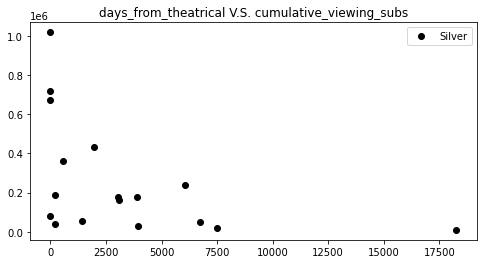

In [255]:
plot_df = training_data[(training_data['medal_number'] == 3) # == 2 only 2 samples and the more days the more views
#                         (training_data['genre_crime'] == 1) 
#                         (training_data['is_direct_to_max_title'] == 0)
                       ]
plt.figure(figsize=(8, 4))
plt.plot(plot_df['days_from_theatrical'], 
         plot_df['cumulative_viewing_subs'], 'o', color='black', label = 'Silver');
plt.title('days_from_theatrical V.S. cumulative_viewing_subs')
plt.legend()

## 1.1 Cross Validation

In [15]:
def cal_error(validation_set):
    error_col = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]
    return error_col.mean()

### 1.11 Random Forest CV - Bench Mark

In [16]:
training_data = training_data[training_data[TARGET_COL[0]].notnull()]

In [17]:
len(training_data)

25

In [18]:
num_folds = len(training_data['title_id'].unique())
group_kfold = GroupKFold(n_splits=num_folds)

In [19]:
validation_set = pd.DataFrame()
feature_importances = pd.DataFrame()
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

for train_index, test_index in group_kfold.split(training_data, groups=training_data['title_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
    print ("Validation Title: " + test_df['title_name'].values[0])
    try:
        ## fit_predict prelaunch model
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

#         fi = model.feature_importances_
#         fi_df = pd.DataFrame([fi])
#         fi_df.columns = FEATURE_COLS
#         fi_df['match_id'] = test_df['match_id'].values[0]
#         fi_df['title_name'] = test_df['title_name'].values[0]
#         fi_df['days_on_hbo_max'] = day
#         feature_importances=pd.concat([feature_importances, fi_df], axis = 0)

    except (KeyboardInterrupt, SystemExit):
        raise

    except:
        print (test_df['title'].values[0] + " Failed!!")
        # raise

Validation Title: Eraser: Reborn
Validation Title: Scoob!
Validation Title: Lights Out


KeyboardInterrupt: 

In [27]:
# validation_set.to_csv('validation_set_low_budget_movies.csv')

In [118]:
validation_set['pct_error'] = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]

In [120]:
cal_error(validation_set)

1.732601454380023

### 1.12 Bayesian Regression CV

In [22]:
# !pip install pygam

In [20]:
from pygam import LinearGAM, s

In [21]:
FEATURE_COLS = ['days_from_theatrical', 'medal_number', 
#                 'genre_comedy', 'genre_drama', 'genre_crime', 
#                 'is_direct_to_max_title'
               ]

In [22]:
TARGET_COL = ['log_cumulative_viewing_subs'] # cumulative_first_views

In [23]:
training_data = training_data[training_data['log_cumulative_viewing_subs'].notnull()]
training_data = training_data[training_data['observed_medal']!= 'Platinum']

In [24]:
num_folds = len(training_data['title_id'].unique())
group_kfold = GroupKFold(n_splits=num_folds)

In [25]:
num_folds

24

In [26]:
training_data[FEATURE_COLS+TARGET_COL].isnull().sum()/len(training_data)

days_from_theatrical          0.00
medal_number                  0.00
log_cumulative_viewing_subs   0.00
dtype: float64

In [27]:
# training_data['area_gross'] = training_data['area_gross'].fillna(0)
# training_data['budget'] = training_data['budget'].fillna(0)

In [28]:
### DOWNSIDE --- DO NOT TAKE NULL ####
validation_set = pd.DataFrame()
# feature_importances = pd.DataFrame()
# gam = LinearGAM(s(0))

for train_index, test_index in group_kfold.split(training_data, groups=training_data['title_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
#     print ("Validation Title: " + test_df['title'].values[0])
    try:
        ## fit_predict prelaunch model
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        gam = LinearGAM(n_splines=6).fit(X_train, y_train)
        pred = gam.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

    except Exception as e:
        print (e)
        raise 

In [29]:
cal_error(validation_set)

0.07935729884302388

In [30]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=10).fit(X, y)

In [31]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.4609
Link Function:                     IdentityLink Log Likelihood:                                   -28.4912
Number of Samples:                           24 AIC:                                               69.9042
                                                AICc:                                              75.7333
                                                GCV:                                                0.3537
                                                Scale:                                              0.2126
                                                Pseudo R-Squared:                                     0.83
Feature Function                  Lam

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  if __name__ == '__main__':


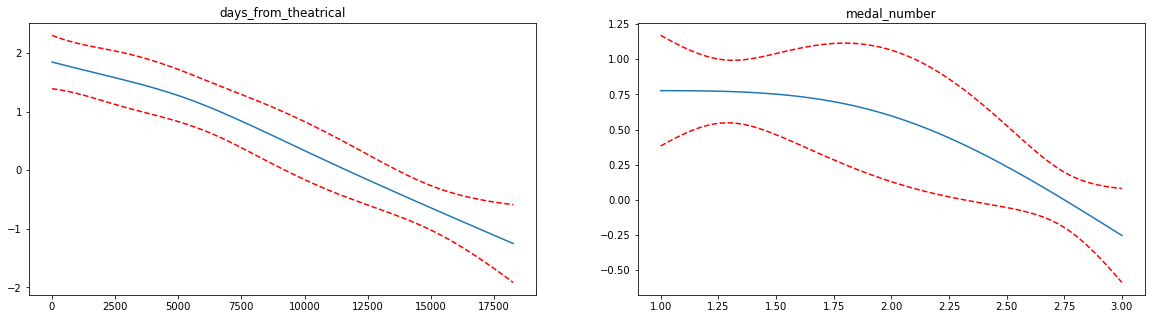

In [32]:
plt.rcParams['figure.figsize'] = (20, 5)
fig, axs = plt.subplots(1, 2)
titles = FEATURE_COLS
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [33]:
def cal_true_error(validation_set):
    error_col = (validation_set['pred_antilog']-validation_set['cumulative_viewing_subs']).abs()/validation_set['cumulative_viewing_subs']
    return error_col.mean()

In [34]:
validation_set['pred_antilog'] = 10**(validation_set['pred'])+9000

In [35]:
cal_true_error(validation_set)

1.1840592277401472

In [36]:
validation_set['pct_error'] = (validation_set['pred_antilog']-validation_set['cumulative_viewing_subs']).abs()/validation_set['cumulative_viewing_subs']

In [37]:
validation_set[validation_set['pct_error']>2][META_COLS+FEATURE_COLS+TARGET_COL+['pred', 'pred_antilog','cumulative_viewing_subs','pct_error']]

,title_name,title_id,days_from_theatrical,medal_number,log_cumulative_viewing_subs,pred,pred_antilog,cumulative_viewing_subs,pct_error
0,Lights Out,GWZsaUQkr0bXCLwEAAABn,1410,3,4.68,5.32,"217,443.29","57,023.00",2.81
0,The Kitchen,GXhzsZA8cqx_DTgEAAADY,191,3,4.49,5.54,"359,226.50","39,837.00",8.02
0,The Time Traveler's Wife,GXrHxIweO4a2brQEAAAC7,3944,3,4.32,4.99,"105,657.57","29,943.00",2.53
0,Scoob!,GXtf0UwTqw8JHjQEAAAbT,177,1,6.04,6.54,"3,448,584.15","1,110,828.00",2.10
0,House Party,GXwOYEAypSMMxPQEAAAAD,0,3,4.85,5.54,"353,522.01","79,884.00",3.43


In [38]:
validation_set[validation_set['days_from_theatrical']>3000]\
                [META_COLS+FEATURE_COLS+TARGET_COL+['pred', 'pred_antilog','cumulative_viewing_subs','pct_error']].\
                sort_values(by = ['days_from_theatrical'])


,title_name,title_id,days_from_theatrical,medal_number,log_cumulative_viewing_subs,pred,pred_antilog,cumulative_viewing_subs,pct_error
0,The Secret Life of Walter Mitty,GYiDXlgDabmOwaQEAAAAE,3019,3,5.23,5.04,"119,147.95","178,919.00",0.33
0,Rock of Ages,GX42i2wFVsqDDwwEAAAAF,3091,3,5.19,5.03,"117,273.40","162,465.00",0.28
0,The Rite,GYKa7VgOEd7TCwgEAAAAD,3899,3,5.23,4.90,"89,005.92","179,073.00",0.50
0,The Time Traveler's Wife,GXrHxIweO4a2brQEAAAC7,3944,3,4.32,4.99,"105,657.57","29,943.00",2.53
0,Domino,GYWgsZw8FNhmKiwEAAABn,6074,3,5.36,4.48,"38,992.90","238,562.00",0.84
0,John Q,GXtZ0GAMvfMPCwgEAAABv,6711,3,4.63,4.48,"39,525.63","51,836.00",0.24
0,Magnolia,GXrQWiQPZl77DwgEAAABw,7502,3,3.90,4.50,"40,771.44","16,904.00",1.41
0,Willard,GXk2j4Arr-I7CZgEAACRd,18263,3,2.32,2.09,"9,123.56","9,209.00",0.01


In [39]:
validation_set.groupby(['observed_medal']).pct_error.mean()

observed_medal
Bronze   1.41
Gold     0.77
Silver   0.34
Name: pct_error, dtype: float64

In [40]:
# validation_set[validation_set['observed_medal'] == 'Platinum']

### 1.13 Bayesian Regression Scoring

##### 1.131 Scoring 1 - Title Level

In [177]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=6).fit(X, y)

In [178]:
pred_day = [*range(0, 200, 15)]
df = pd.DataFrame(pred_day, columns =['days_from_theatrical'])

In [179]:
scoring_data = training_data[META_COLS+FEATURE_COLS].copy()
scoring_data.drop(['days_from_theatrical'], axis = 1, inplace = True)

In [180]:
def cartesian_product_basic(left, right):
    return (
       left.assign(key=1).merge(right.assign(key=1), on='key').drop('key', 1))

In [181]:
scoring_data=cartesian_product_basic(scoring_data, df)

In [182]:
pred = gam.predict(scoring_data[FEATURE_COLS])
pred = pd.DataFrame(pred)
pred.columns = ['pred']
scoring_data = pd.concat([scoring_data, pred], axis = 1)

In [183]:
scoring_data['pred'] = 10**(scoring_data['pred'])+9000

In [184]:
scoring_data['kpi'] = 'viewing_subs'

In [185]:
scoring_data_45 = scoring_data[scoring_data['days_from_theatrical'] == 45][['title_id', 'medal_number', 'pred']]
scoring_data = scoring_data.merge(scoring_data_45.rename(columns = {'pred':'pred_45'}), 
                                  on = ['title_id', 'medal_number'])
scoring_data['multiplier'] = scoring_data['pred']/scoring_data['pred_45']

In [186]:
scoring_data.tail()

,title_name,title_id,observed_medal,medal_number,days_from_theatrical,pred,kpi,pred_45,multiplier
331,Domino,GYWgsZw8FNhmKiwEAAABn,Bronze,3,135,"12,339.54",viewing_subs,"12,431.73",0.99
332,Domino,GYWgsZw8FNhmKiwEAAABn,Bronze,3,150,"12,324.42",viewing_subs,"12,431.73",0.99
333,Domino,GYWgsZw8FNhmKiwEAAABn,Bronze,3,165,"12,309.37",viewing_subs,"12,431.73",0.99
334,Domino,GYWgsZw8FNhmKiwEAAABn,Bronze,3,180,"12,294.38",viewing_subs,"12,431.73",0.99
335,Domino,GYWgsZw8FNhmKiwEAAABn,Bronze,3,195,"12,279.47",viewing_subs,"12,431.73",0.99


In [191]:
OUTPUT_COLS = ['title_id', 'title_name', 'observed_medal', 'medal_number', 'days_from_theatrical', 'kpi', 'pred', 'multiplier']

In [192]:
write_to_sf(scoring_data[OUTPUT_COLS], 'low_budget_title_level_subs')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



In [169]:
import plotly.express as px

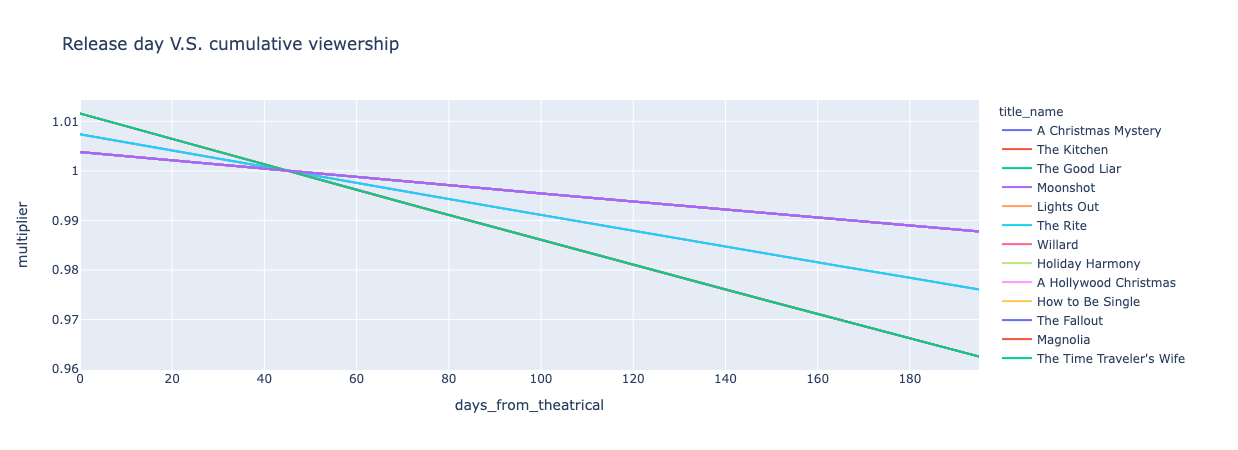

In [188]:
plot_df = scoring_data
fig = px.line(plot_df, x="days_from_theatrical", y="multiplier", color = 'title_name',
              title='Release day V.S. cumulative viewership')
fig.show()

##### 1.132 Scoring2

In [193]:
scoring_data = training_data[META_COLS+FEATURE_COLS].copy()
scoring_data.drop(['days_from_theatrical'], axis = 1, inplace = True)

In [194]:
scoring_data = scoring_data.groupby(['medal_number', 'observed_medal']).max().reset_index()

In [195]:
scoring_data = scoring_data[['medal_number', 'observed_medal']]

In [196]:
pred_day = [*range(0, 1800, 15)]
df = pd.DataFrame(pred_day, columns =['days_from_theatrical'])

In [197]:
scoring_data=cartesian_product_basic(scoring_data, df)

In [198]:
pred = gam.predict(scoring_data[FEATURE_COLS])
pred = pd.DataFrame(pred)
pred.columns = ['pred']
scoring_data = pd.concat([scoring_data, pred], axis = 1)

In [199]:
scoring_data['pred'] = 10**(scoring_data['pred'])+9000

In [200]:
scoring_data['title_id'] = np.NAN
scoring_data['title_name'] = np.NAN
scoring_data['kpi'] = 'viewing_subs'

In [201]:
scoring_data_45 = scoring_data[scoring_data['days_from_theatrical'] == 45][['medal_number', 'pred']]
scoring_data = scoring_data.merge(scoring_data_45.rename(columns = {'pred':'pred_45'}), 
                                  on = ['medal_number'])
scoring_data['multiplier'] = scoring_data['pred']/scoring_data['pred_45']

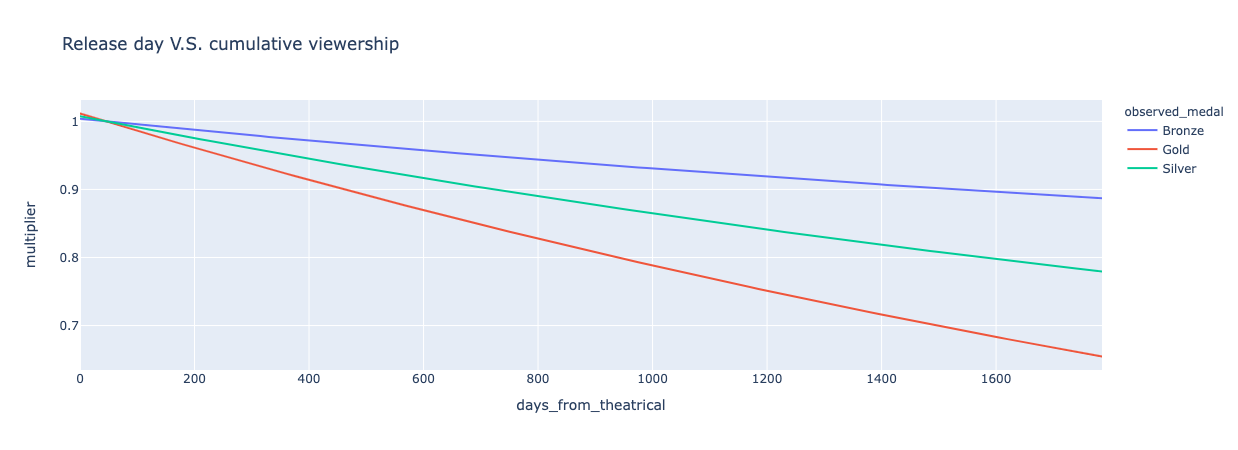

In [202]:
plot_df = scoring_data.groupby(['days_from_theatrical', 'observed_medal']).mean().reset_index()
fig = px.line(plot_df, x="days_from_theatrical", y="multiplier", color = 'observed_medal',
              title='Release day V.S. cumulative viewership')
fig.show()

In [203]:
write_to_sf(scoring_data[OUTPUT_COLS], 'low_budget_medal_level_subs')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



# 2. First Views

In [212]:
training_data['log_cumulative_first_views'] = np.log10(training_data['cumulative_first_views']-40)

In [213]:
# training_data['power_cumulative_first_views'] = np.power(training_data['cumulative_first_views'], (1/4))

In [214]:
FEATURE_COLS = ['days_from_theatrical', 'medal_number']
                #, 'genre_Horror ', 'genre_Kids/Family', 'genre_Romance', 'genre_Sci-Fi', 'genre_Suspense/Thriller', 'medal_Bronze', 'medal_Gold'

In [215]:
TARGET_COL = ['log_cumulative_first_views'] # cumulative_first_views

## 2.1 Cross Validation

In [216]:
def cal_error(validation_set):
    error_col = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]].abs()
    return error_col.mean()

### 2.11 Random Forest CV - Bench Mark

In [118]:
num_folds = len(training_data['title_id'].unique())
group_kfold = GroupKFold(n_splits=num_folds)

In [119]:
num_folds

24

In [120]:
training_data.head()

,Unnamed: 0,title_name,title_id,primary_genre_desc,program_type,theatrical_release_date,asset_run_time,offering_start_date,offering_end_date,is_direct_to_max_title,licensor,observed_medal,days_on_hbo_max,cumulative_viewing_subs,cumulative_first_views,percent_cumulative_viewing_subscribers,percent_cumulative_first_views,imdb_id,area_gross,budget,days_from_theatrical,genre_action,genre_comedy,genre_crime,genre_drama,genre_fantasy & sci-fi,genre_horror,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views,log_cumulative_viewing_subs
0,0,A Christmas Mystery,GY2QUhg4BOJ_DwgEAAAD-,comedy,acquired,2022-11-24,"5,224.00",2022-11-24 08:01:00,2026-05-06 03:59:00,1,"Warner Bros. Inc., Warner Media Direct, LLC",Bronze,90.00,"670,922.00","3,898.00",2.13,0.08,tt22207152,nan,nan,0,0,1,0,0,0,0,1,0,0,0,3,3.59,5.82
1,1,The Kitchen,GXhzsZA8cqx_DTgEAAADY,crime,acquired,2019-09-20,"6,153.00",2020-03-29 00:00:00,2020-12-01 10:59:00,0,WARNER BROS. INC.,Bronze,90.00,"39,837.00","2,045.00",0.51,0.03,tt5822564,"5,527,410.00","38,000,000.00",191,0,0,1,0,0,0,1,0,0,0,3,3.30,4.49
2,2,The Good Liar,GXpTQtgV6ax-auwEAABc3,crime,acquired,2019-11-15,"6,574.00",2020-06-14 00:00:00,2021-03-01 10:59:00,0,WARNER BROS. INC.,Bronze,90.00,"186,115.00","10,519.00",2.22,0.18,tt5563334,"5,605,051.00","10,000,000.00",212,0,0,1,0,0,0,1,0,0,0,3,4.02,5.25
3,3,Moonshot,GYhfK9AxT1KKnnQEAAADT,comedy,acquired,2022-03-31,"6,123.00",2022-03-31 07:01:00,2022-07-01 03:59:00,1,"Warner Bros. Domestic Television Distribution,...",Silver,90.00,"1,791,406.00","10,045.00",6.01,0.25,tt12585076,nan,nan,0,0,1,0,0,0,0,0,0,0,1,2,4.00,6.25
4,4,Lights Out,GWZsaUQkr0bXCLwEAAABn,horror,acquired,2016-07-22,"4,755.00",2020-06-01 10:00:00,2020-12-11 10:59:00,0,WARNER BROS. INC.,Bronze,90.00,"57,023.00","1,956.00",0.72,0.03,tt4786282,"21,688,103.00","4,900,000.00",1410,0,0,0,0,0,1,1,0,0,0,3,3.28,4.68


In [121]:
validation_set = pd.DataFrame()
feature_importances = pd.DataFrame()
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

for train_index, test_index in group_kfold.split(training_data, groups=training_data['title_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
    print ("Validation Title: " + test_df['title_name'].values[0])
    try:
        ## fit_predict prelaunch model
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

#         fi = model.feature_importances_
#         fi_df = pd.DataFrame([fi])
#         fi_df.columns = FEATURE_COLS
#         fi_df['match_id'] = test_df['match_id'].values[0]
#         fi_df['title_name'] = test_df['title_name'].values[0]
#         fi_df['days_on_hbo_max'] = day
#         feature_importances=pd.concat([feature_importances, fi_df], axis = 0)

    except (KeyboardInterrupt, SystemExit):
        raise

    except:
        print (test_df['title'].values[0] + " Failed!!")
        # raise

Validation Title: Eraser: Reborn
Validation Title: The Secret Life of Walter Mitty


KeyboardInterrupt: 

In [ ]:
# validation_set.to_csv('validation_set.csv')

In [ ]:
validation_set['pct_error'] = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]

In [112]:
validation_set.head()

,Unnamed: 0,title_name,title_id,primary_genre_desc,program_type,theatrical_release_date,asset_run_time,offering_start_date,offering_end_date,is_direct_to_max_title,licensor,observed_medal,days_on_hbo_max,cumulative_viewing_subs,cumulative_first_views,percent_cumulative_viewing_subscribers,percent_cumulative_first_views,imdb_id,area_gross,budget,days_from_theatrical,genre_action,genre_comedy,genre_crime,genre_drama,genre_fantasy & sci-fi,genre_horror,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views,log_cumulative_viewing_subs,pred,pct_error
0,17,Eraser: Reborn,GYtUdUQtVN3mangEAAAox,action,acquired,2022-01-01,"6,016.00",2022-10-05 07:01:00,2025-10-05 03:59:00,0,"Warner Bros. Domestic Television Distribution,...",Silver,90.00,"1,877,923.00","8,118.00",6.08,0.17,tt15422240,nan,nan,277,1,0,0,0,0,0,0,0,0,1,2,3.91,6.27,4.42,0.13
0,18,The Secret Life of Walter Mitty,GYiDXlgDabmOwaQEAAAAE,comedy,acquired,2013-12-25,"6,871.00",2022-04-01 07:01:00,2023-04-01 07:00:00,0,TWENTIETH CENTURY FOX FILM CORPORATION,Bronze,90.00,"178,919.00",578.00,0.60,0.01,tt0359950,"12,765,508.00","90,000,000.00",3019,0,1,0,0,0,0,1,0,0,0,3,2.76,5.23,3.61,0.31
0,4,Lights Out,GWZsaUQkr0bXCLwEAAABn,horror,acquired,2016-07-22,"4,755.00",2020-06-01 10:00:00,2020-12-11 10:59:00,0,WARNER BROS. INC.,Bronze,90.00,"57,023.00","1,956.00",0.72,0.03,tt4786282,"21,688,103.00","4,900,000.00",1410,0,0,0,0,0,1,1,0,0,0,3,3.29,4.68,3.35,0.02
0,14,Rock of Ages,GX42i2wFVsqDDwwEAAAAF,comedy,acquired,2012-06-15,"7,401.00",2020-12-01 11:00:00,2021-07-01 07:00:00,0,WARNER BROS. INC.,Bronze,90.00,"162,465.00","4,108.00",0.82,0.04,tt1336608,"14,437,269.00","75,000,000.00",3091,0,1,0,0,0,0,1,0,0,0,3,3.61,5.19,2.76,0.24
0,23,Locked Down,GX_3YsgTKcK_CSwEAAAAp,comedy,original,2021-01-14,"6,857.00",2021-01-14 08:01:00,2022-07-01 03:59:00,1,"The Floating Opera Company, Warner Media Direc...",Gold,90.00,"1,923,881.00","33,121.00",8.30,0.36,tt13061914,nan,nan,0,0,1,0,0,0,0,0,1,0,0,1,4.52,6.28,4.64,0.03


In [121]:
cal_error(validation_set) #0.062

0.13380833404721723

In [122]:
def cal_true_error(validation_set):
    error_col = (validation_set['pred_antilog']-validation_set['cumulative_first_views']).abs()/validation_set['cumulative_first_views']
    return error_col.mean()

In [124]:
validation_set['pred_antilog'] = 10**validation_set['pred']

In [125]:
cal_true_error(validation_set)

1.6405808126776682

### 2.12 Bayesian Regression CV

In [129]:
# !pip install pygamx

In [208]:
from pygam import LinearGAM, s, PoissonGAM

In [209]:
training_data[FEATURE_COLS].isnull().sum()/len(training_data)

days_from_theatrical   0.00
medal_number           0.00
dtype: float64

In [107]:
# training_data['area_gross'] = training_data['area_gross'].fillna(0)
# training_data['budget'] = training_data['budget'].fillna(0)

In [108]:
### DOWNSIDE --- DO NOT TAKE NULL ####
validation_set = pd.DataFrame()
# feature_importances = pd.DataFrame()
# gam = LinearGAM(s(0))

for train_index, test_index in group_kfold.split(training_data, groups=training_data['title_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
#     print ("Validation Title: " + test_df['title'].values[0])
    try:
        ## fit_predict prelaunch model|
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        gam = LinearGAM(n_splines=5).fit(X_train, y_train)
        pred = gam.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

    except Exception as e:
        print (e)
        raise 

In [109]:
cal_error(validation_set) # 0.040

0.11582432410450595

In [110]:
def cal_true_error(validation_set):
    error_col = (validation_set['pred_antilog']-validation_set['cumulative_first_views']).abs()/validation_set['cumulative_first_views']
    return error_col.mean()

In [111]:
validation_set['pred_antilog'] = 10**(validation_set['pred'])+40

In [112]:
cal_true_error(validation_set)

0.5996978884701656

In [113]:
validation_set['pct_error'] = (validation_set['pred_antilog']-validation_set['cumulative_first_views']).abs()/validation_set['cumulative_first_views']

In [114]:
validation_set[validation_set['pct_error']>1][META_COLS + FEATURE_COLS + TARGET_COL+['pred_antilog', 'cumulative_first_views']]

,title_name,title_id,observed_medal,days_from_theatrical,medal_number,log_cumulative_first_views,pred_antilog,cumulative_first_views
0,The Secret Life of Walter Mitty,GYiDXlgDabmOwaQEAAAAE,Bronze,3019,3,2.73,"1,488.84",578.00
0,Little Nicky,GYPW0-A4V68MloQEAAAEX,Bronze,549,3,3.10,"3,264.20","1,300.00"
0,Domino,GYWgsZw8FNhmKiwEAAABn,Bronze,6074,3,2.39,597.51,285.00
0,Kimi,GYeB2LgKJ1cIOjAEAAABQ,Gold,0,1,4.33,"58,321.28","21,648.00"


In [115]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=10).fit(X, y)

In [116]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.4609
Link Function:                     IdentityLink Log Likelihood:                                   -65.4731
Number of Samples:                           24 AIC:                                               143.868
                                                AICc:                                             149.6971
                                                GCV:                                                0.1532
                                                Scale:                                              0.0921
                                                Pseudo R-Squared:                                   0.9124
Feature Function                  Lam

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




In [117]:
import matplotlib.pyplot as plt

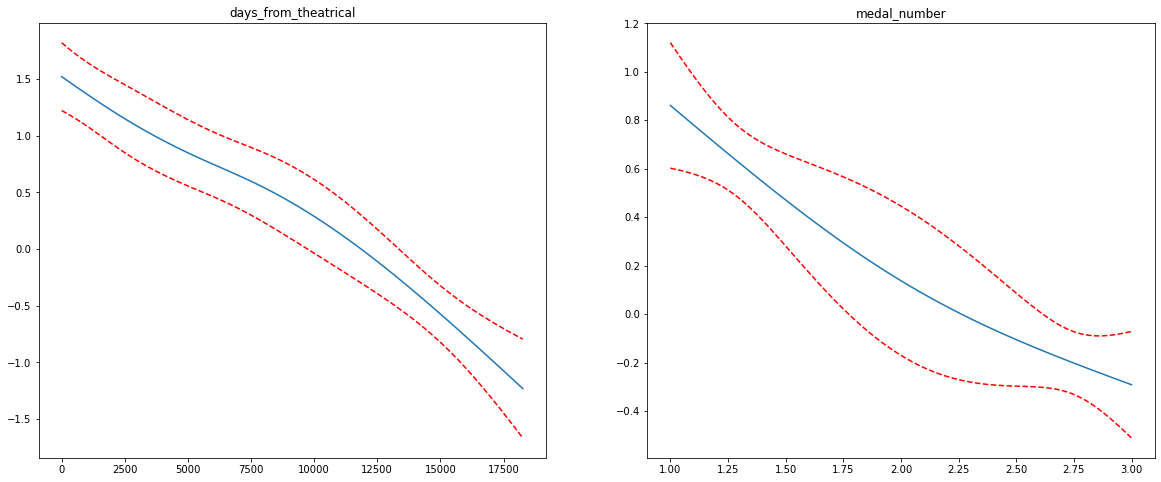

In [118]:
plt.rcParams['figure.figsize'] = (20, 8)
fig, axs = plt.subplots(1, 2)
titles = FEATURE_COLS
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [119]:
validation_set.groupby(['medal_number']).pct_error.mean()

medal_number
1   0.68
2   0.33
3   0.61
Name: pct_error, dtype: float64

### 2.13 GAM Scoring

##### 2.131 Scoring 1

In [232]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=5).fit(X, y)

In [233]:
pred_day = [*range(0, 200, 15)]
df = pd.DataFrame(pred_day, columns =['days_from_theatrical'])

In [234]:
scoring_data = training_data[META_COLS+FEATURE_COLS].copy()
scoring_data.drop(['days_from_theatrical'], axis = 1, inplace = True)

In [235]:
def cartesian_product_basic(left, right):
    return (
       left.assign(key=1).merge(right.assign(key=1), on='key').drop('key', 1))

In [236]:
scoring_data=cartesian_product_basic(scoring_data, df)

In [237]:
pred = gam.predict(scoring_data[FEATURE_COLS])
pred = pd.DataFrame(pred)
pred.columns = ['pred']
scoring_data = pd.concat([scoring_data, pred], axis = 1)

In [238]:
scoring_data.head()

,title_name,title_id,observed_medal,medal_number,days_from_theatrical,pred
0,A Christmas Mystery,GY2QUhg4BOJ_DwgEAAAD-,Bronze,3,0,3.55
1,A Christmas Mystery,GY2QUhg4BOJ_DwgEAAAD-,Bronze,3,15,3.55
2,A Christmas Mystery,GY2QUhg4BOJ_DwgEAAAD-,Bronze,3,30,3.55
3,A Christmas Mystery,GY2QUhg4BOJ_DwgEAAAD-,Bronze,3,45,3.54
4,A Christmas Mystery,GY2QUhg4BOJ_DwgEAAAD-,Bronze,3,60,3.54


In [239]:
scoring_data['pred'] = 10**(scoring_data['pred'])+40

In [240]:
scoring_data['kpi'] = 'first_views'

In [241]:
scoring_data_45 = scoring_data[scoring_data['days_from_theatrical'] == 45][['title_id', 'pred']].rename(columns = {'pred':'base'}).copy()
scoring_data = scoring_data.merge(scoring_data_45, on = ['title_id'])
scoring_data['multiplier'] = scoring_data['pred']/scoring_data['base']

In [242]:
write_to_sf(scoring_data[OUTPUT_COLS], 'low_budget_title_level_first_views')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



In [131]:
import plotly.express as px

In [132]:
# plot_df = scoring_data
# fig = px.line(plot_df, x="days_from_theatrical", y="multipler", color = 'title_name',
#               title='Release day V.S. cumulative viewership')
# fig.show()

##### 2.132 Scoring2

In [243]:
scoring_data = training_data[META_COLS+FEATURE_COLS].copy()
scoring_data.drop(['days_from_theatrical'], axis = 1, inplace = True)

In [244]:
scoring_data = scoring_data[['observed_medal', 'medal_number']]

In [245]:
scoring_data = scoring_data.groupby(['observed_medal', 'medal_number']).max().reset_index()

In [246]:
pred_day = [*range(0, 1800, 15)]
df = pd.DataFrame(pred_day, columns =['days_from_theatrical'])

In [247]:
scoring_data=cartesian_product_basic(scoring_data, df)

In [248]:
pred = gam.predict(scoring_data[FEATURE_COLS])
pred = pd.DataFrame(pred)
pred.columns = ['pred']
scoring_data = pd.concat([scoring_data, pred], axis = 1)

In [249]:
scoring_data['pred'] = 10**(scoring_data['pred'])+40

In [250]:
scoring_data['title_id'] = np.NAN
scoring_data['title_name'] = np.NAN
scoring_data['kpi'] = 'first_views'

In [251]:
scoring_data_45 = scoring_data[scoring_data['days_from_theatrical'] == 45][['medal_number', 'pred']]
scoring_data = scoring_data.merge(scoring_data_45.rename(columns = {'pred':'pred_45'}), 
                                  on = ['medal_number'])
scoring_data['multiplier'] = scoring_data['pred']/scoring_data['pred_45']

In [252]:
scoring_data.head()

,observed_medal,medal_number,days_from_theatrical,pred,title_id,title_name,kpi,pred_45,multiplier
0,Bronze,3,0,"3,584.75",nan,nan,first_views,"3,534.73",1.01
1,Bronze,3,15,"3,568.00",nan,nan,first_views,"3,534.73",1.01
2,Bronze,3,30,"3,551.32",nan,nan,first_views,"3,534.73",1.00
3,Bronze,3,45,"3,534.73",nan,nan,first_views,"3,534.73",1.00
4,Bronze,3,60,"3,518.22",nan,nan,first_views,"3,534.73",1.00


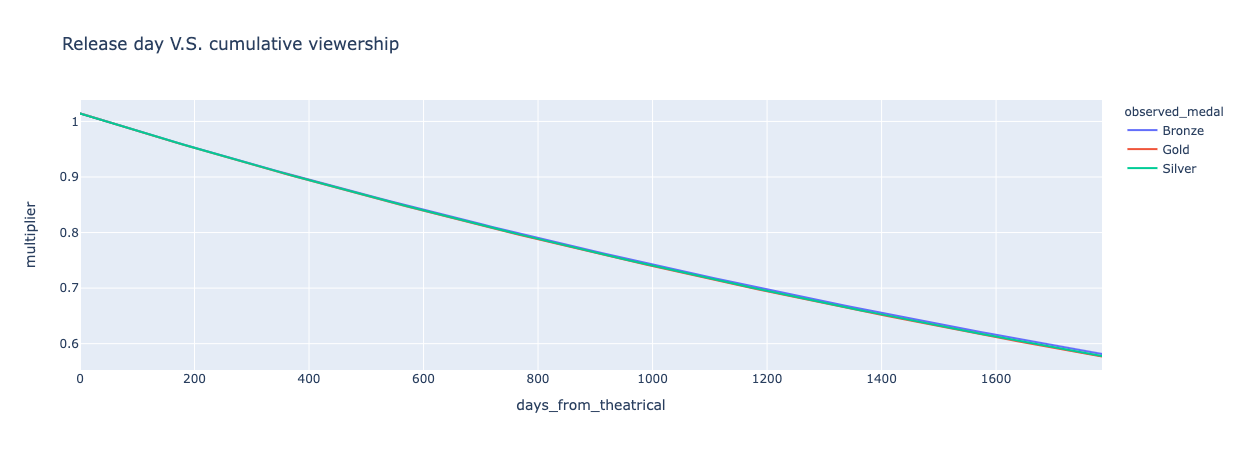

In [253]:
plot_df = scoring_data.groupby(['days_from_theatrical', 'observed_medal']).mean().reset_index()
fig = px.line(plot_df, x="days_from_theatrical", y="multiplier", color = 'observed_medal',
              title='Release day V.S. cumulative viewership')
fig.show()

In [254]:
write_to_sf(scoring_data[OUTPUT_COLS], 'low_budget_medal_level_first_views')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



# WRITE TO SF

In [214]:
import boto3
import io

In [55]:
## WRITE OR READ FROM S3 ####
import boto3
import io

s3 = boto3.resource('s3')
output_bucket = "hbo-outbound-datascience-content-dev"
input_bucket = "hbo-ingest-datascience-content-dev"
bucket = s3.Bucket(input_bucket)

def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'movie_windowing/{}.csv'.format(file_name)
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
def write_to_input(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'movie_windowing/{}.csv'.format(file_name)
    client = boto3.client('s3')
    client.put_object(Bucket=input_bucket, Key=filename, Body=content)
    
def read_from_s3(filename, input_bucket = input_bucket):
    for obj in bucket.objects.filter(Prefix='movie_windowing/'+filename): #churn_metric_0811
            key = obj.key 
            body = obj.get()['Body']
            print('Reading {0} features'.format(key))
            df = pd.read_csv(body, na_values = [r'\\\\N'])
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [56]:
# OUTPUT_COLS = ['title_id', 'imdb_id', 'title', 'home_territory_observed_medal', 'pillar_genres', 'area_gross', 'medal_number', 'budget', 'days_from_theatrical2', 'kpi', 'pred']

In [57]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

In [154]:
run_query('''
create or replace table max_dev.workspace.movie_window_prediction_title_level_subs
(
title_id	VARCHAR,
imdb_id	VARCHAR,
title	VARCHAR,
home_territory_observed_medal	VARCHAR,
pillar_genres	VARCHAR,
area_gross	FLOAT,
medal_number	INT,
budget	FLOAT,
days_from_theatrical2	INT,
kpi	VARCHAR,
pred FLOAT
);

''')


,status
0,Table MOVIE_WINDOW_PREDICTION_TITLE_LEVEL_SUBS...


In [18]:
# run_query('''
# create or replace table max_dev.workspace.movie_window_prediction_actual_value
# (
# title_id	VARCHAR,
# days_from_theatrical2 int,
# value FLOAT,
# kpi	VARCHAR
# );

# ''')

,status
0,Table MOVIE_WINDOW_PREDICTION_ACTUAL_VALUE suc...


In [ ]:
#first_views #genre_level_first_views

In [155]:
run_query('''
copy into max_dev.workspace.movie_window_prediction_title_level_subs
    from(
        select
              $1, $2, $3, $4, $5, $6, $7, $8, $9, $10, $11
        from @HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV/movie_windowing/movie_window_prediction_title_level_subs.csv
        )
    file_format = (type = csv null_if=('') skip_header = 1  FIELD_OPTIONALLY_ENCLOSED_BY='"')
    on_error = 'CONTINUE';

''')

,file,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
0,s3://hbo-outbound-datascience-content-dev/movi...,LOADED,1022,1022,1022,0,None,None,None,None


In [19]:
# run_query('''
# copy into max_dev.workspace.movie_window_prediction_actual_value
#     from(
#         select
#               $1, $2, $3, $4
#         from @HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV/movie_windowing/movie_window_prediction_actual_value.csv
#         )
#     file_format = (type = csv null_if=('') skip_header = 1  FIELD_OPTIONALLY_ENCLOSED_BY='"')
#     on_error = 'CONTINUE';

# ''')

,file,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
0,s3://hbo-outbound-datascience-content-dev/movi...,LOADED,206,206,206,0,None,None,None,None


In [189]:
training_data.head()

,Unnamed: 0,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,theatrical_release_date,offering_start_date,days_from_theatrical2,pct_actives,days_from_max_launch,cumulative_viewing_subs,cumulative_first_views,area_gross,budget,genre_Action/Adventure,genre_Comedy,genre_Drama,genre_Horror,genre_Kids/Family,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,medal_number,platform,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,log_cumulative_first_views
0,0,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,2020-12-25,2021-09-05,250,0.09,-219,2557041,25362,"2,250,430.00","38,000,000.00",1,0,0,0,0,0,0,0,2,1.00,0,0,0,1,14.63
3,3,GYbzvWABDj8LDwgEAAAAp,The Last Duel,Gold,Drama,tt4244994,2021-10-15,2022-01-14,91,0.16,-513,5012315,33314,"4,759,151.00","100,000,000.00",0,0,1,0,0,0,0,0,1,1.00,0,1,0,0,15.02
4,4,GYm0w5wSRXaTDYQEAAAD4,Last Night in Soho,Silver,Suspense/Thriller,tt9639470,2021-10-29,2022-07-01,245,0.07,-527,2005376,8975,"4,178,460.00","43,000,000.00",0,0,0,0,0,0,0,1,2,1.00,0,0,0,1,13.13
6,6,GYd9P0QTRLMLDJwEAAAAP,Antlers,Silver,Horror,tt7740510,2021-10-11,2022-02-11,123,0.09,-509,2614867,14444,"4,271,346.00",0.00,0,0,0,1,0,0,0,0,2,1.00,0,0,0,1,13.82
7,7,GYfinBwyKBImYsgEAAACn,Halloween Kills,Silver,Horror,tt10665338,2021-10-15,2022-03-18,137,0.10,-513,2838005,28030,"49,404,980.00","20,000,000.00",0,0,0,1,0,0,0,0,2,1.00,0,0,0,1,14.77


In [15]:
df1 = training_data[['title_id', 'days_from_theatrical2', 'cumulative_viewing_subs']].rename(columns = {'cumulative_viewing_subs':'value'})
df1['kpi'] = 'viewing_subs'
df2 = training_data[['title_id', 'days_from_theatrical2', 'cumulative_first_views']].rename(columns = {'cumulative_first_views':'value'})
df2['kpi'] = 'first_views'
actual_data = pd.concat([df1, df2], axis = 0)

In [16]:
write_to_sf(actual_data, 'actual_value')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [1]:
actual_data.tail()

NameError: name 'actual_data' is not defined